In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm

In [3]:
import torch
from torch_geometric.data import Data, DataLoader

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
# from deepadr.model_gnn import GCN as testGCN
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf
# from deepadr.model_attn_siamese import *
from ogb.graphproppred import Evaluator
os.chdir(cwd)

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
# from tdc.single_pred import Tox
from tdc.multi_pred import DDI

In [8]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [9]:
report_available_cuda_devices()

number of GPUs available: 1
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB



In [10]:
n_gpu = torch.cuda.device_count()
n_gpu

1

In [11]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

### Preparing dataset 

In [12]:
# TDC Tox
DSdataset_name = 'TWOSIDES' #'DrugBank'

#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [13]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# # ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))
print(targetdata_dir)

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
/cluster/home/skyriakos/chemprop_run/git/data/processed/TWOSIDES/data_v1


In [14]:
%%time
dataset = MoleculeDataset(root=targetdata_dir)

CPU times: user 6.12 ms, sys: 635 ms, total: 641 ms
Wall time: 633 ms


In [15]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: MoleculeDataset(149878):
Number of graphs: 149878
Number of features: 9
Number of classes: 2


In [16]:
data0

PairData(edge_attr_a=[52, 3], edge_attr_b=[22, 3], edge_index_a=[2, 52], edge_index_b=[2, 22], id=[1], x_a=[24, 9], x_b=[12, 9], y=[1])

In [17]:
len(dataset)

149878

In [18]:
used_dataset = dataset

smaller_dataset_len = int(len(dataset)/5)
used_dataset = dataset[:smaller_dataset_len]

In [19]:
train_val_test_frac = [0.7, 0.1, 0.2]
assert sum(train_val_test_frac) == 1

torch.manual_seed(42)
used_dataset = used_dataset.shuffle()

num_train = round(train_val_test_frac[0] * len(used_dataset)) 
num_trainval = round((train_val_test_frac[0]+train_val_test_frac[1]) * len(used_dataset))

train_dataset = used_dataset[:num_train]
val_dataset = used_dataset[num_train:num_trainval]
test_dataset = used_dataset[num_trainval:]

In [20]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 20982
Number of val graphs: 2998
Number of test graphs: 5995


In [21]:
train_dataset[3]

PairData(edge_attr_a=[66, 3], edge_attr_b=[66, 3], edge_index_a=[2, 66], edge_index_b=[2, 66], id=[1], x_a=[29, 9], x_b=[30, 9], y=[1])

In [22]:
batch_size=32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, follow_batch=['x_a', 'x_b'])
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, follow_batch=['x_a', 'x_b'])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, follow_batch=['x_a', 'x_b'])

In [23]:
print(dataset.num_classes)

2


In [24]:
# model_intermediate_dimension = 64
emb_dim = 300

In [25]:
# model_name = "testGCN"

# deepadr_model = testGCN(num_node_features=dataset.num_node_features, 
#             hidden_channels=64, 
#             num_classes=model_intermediate_dimension)
# print(deepadr_model)

In [26]:
model_name = "ogb"

gnn_model = GNN(gnn_type = 'gcn', 
                    num_tasks = dataset.num_classes, 
                    num_layer = 5, 
                    emb_dim = emb_dim, 
                    drop_ratio = 0.5, 
                    virtual_node = False,
                    with_edge_attr=False,
                    return_multilayer = True).to(device_gpu)
#print(deepadr_model)

In [27]:
input_embed_dim = None
num_attn_heads = 2
num_transformer_units = 1
p_dropout = 0.3
nonlin_func = nn.ReLU()
mlp_embed_factor = 2
pooling_mode = 'attn'

dist_opt = 'cosine'
l2_reg = 1e-6
batch_size = 1000
num_epochs = 100
loss_w = 0.05
margin_v = 1.

transformer_model = DeepAdr_Transformer(input_size=emb_dim,
                                        input_embed_dim=input_embed_dim,
                                        num_attn_heads=num_attn_heads,
                                        mlp_embed_factor=mlp_embed_factor,
                                        nonlin_func=nonlin_func,
                                        pdropout=p_dropout,
                                        num_transformer_units=num_transformer_units,
                                        pooling_mode=pooling_mode).to(device_gpu)

In [28]:
deepadr_siamese = DeepAdr_SiameseTrf(input_dim=emb_dim,
                                   dist=dist_opt,
                                   num_classes=dataset.num_classes).to(device_gpu)

updated


In [29]:
models_param = list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(deepadr_siamese.parameters())

models = [(gnn_model, f'{model_name}_GNN'),
          (transformer_model, f'{model_name}_Transformer'),
          (deepadr_siamese, f'{model_name}_Siamese')]
#models

In [30]:
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(models_param, lr=0.001)
# criterion = torch.nn.CrossEntropyLoss()

# loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
loss_nlll = torch.nn.NLLLoss(reduction='mean')  # negative log likelihood loss
loss_contrastive = ContrastiveLoss(0.5, reduction='mean')
fdtype = torch.float32
loss_w = 0.1

# evaluator = Evaluator(DSdataset_name)

In [31]:
def train():
    for m, m_name in models:
        m.train()

        #            for i_batch, samples_batch in enumerate(data_loader):

#     for data in train_loader:  # Iterate in batches over the training dataset.
    for i_batch, batch in enumerate(tqdm(train_loader, desc="Iteration")):
        batch = batch.to(device_gpu)
#         print("running batch:", i_batch)
        # x, edge_index, edge_attr, batch
        h_a = gnn_model(batch.x_a, batch.edge_index_a, batch.edge_attr_a, batch.x_a_batch)
        h_b = gnn_model(batch.x_b, batch.edge_index_b, batch.edge_attr_b, batch.x_b_batch)
        
        z_a, fattn_w_scores_a = transformer_model(h_a)
        z_b, fattn_w_scores_b = transformer_model(h_b)
        
#         print("h_a shape:", h_a.shape)
#         print("z_a shape:", z_a.shape)
        
        logsoftmax_scores, dist = deepadr_siamese(z_a, z_b)
#         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#         loss = criterion(out, samples_batch.y)  # Compute the loss.
        cl = loss_nlll(logsoftmax_scores, batch.y)            
        dl = loss_contrastive(dist.reshape(-1), batch.y.type(fdtype))          
        loss = loss_w*cl + (1-loss_w)*dl
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def eval(loader, dsettype):
    for m, m_name in models:
        m.eval()
        
    pred_class = []
    ref_class = []
    prob_scores = []
    
#     for data in loader:  # Iterate in batches over the training/test dataset.
    for i_batch, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device_gpu)
#         out = model(data.x, data.edge_index, data.batch)  
        h_a = gnn_model(batch.x_a, batch.edge_index_a, batch.edge_attr_a, batch.x_a_batch)
        h_b = gnn_model(batch.x_b, batch.edge_index_b, batch.edge_attr_b, batch.x_b_batch)
        
        z_a, fattn_w_scores_a = transformer_model(h_a)
        z_b, fattn_w_scores_b = transformer_model(h_b)
        
#         logsoftmax_scores, dist = deepadr_siamese(z_a, z_b)
        
#         __, y_pred_clss = torch.max(logsoftmax_scores, -1)
#         y_pred_prob  = torch.exp(logsoftmax_scores.detach().cpu()).numpy()

#         pred_class.extend(y_pred_clss.view(-1).tolist())
#         ref_class.extend(batch.y.view(-1).tolist())
# #         prob_scores.append(y_pred_prob)
#         prob_scores.extend(y_pred_prob.view(-1).tolist())
    
        logsoftmax_scores, dist = deepadr_siamese(z_a, z_b)

        __, y_pred_clss = torch.max(logsoftmax_scores, -1)

        y_pred_prob  = torch.exp(logsoftmax_scores.detach().cpu()).numpy()

        pred_class.extend(y_pred_clss.view(-1).tolist())
        ref_class.extend(batch.y.view(-1).tolist())
        prob_scores.append(y_pred_prob)

    prob_scores_arr = np.concatenate(prob_scores, axis=0)
    modelscore = perfmetric_report(pred_class, ref_class, prob_scores_arr[:,1], epoch,
                                  outlog = os.path.join(targetdata_dir_processed, dsettype + ".log"))
#     modelscore = perfmetric_report(pred_class, ref_class, prob_scores, epoch, "")        
    
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         correct += int((pred == samples_batch.y).sum())  # Check against ground-truth labels.
#     return correct / len(loader.dataset)  # Derive ratio of correct predictions.
    return modelscore

In [32]:
%%time

valid_curve = []
test_curve = []
train_curve = []

for epoch in range(100):
    print("=====Epoch {}".format(epoch))
    print('Training...')
#     train(model, device, train_loader, optimizer, dataset.task_type)
    train()

    print('Evaluating...')
#     train_perf = eval(model, device, train_loader, evaluator)
#     valid_perf = eval(model, device, valid_loader, evaluator)
#     test_perf = eval(model, device, test_loader, evaluator)
    train_perf = eval(train_loader, dsettype="train")
    valid_perf = eval(valid_loader, dsettype="valid")
    test_perf = eval(test_loader, dsettype="test")

    print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

    train_curve.append(train_perf.s_aupr)
    valid_curve.append(valid_perf.s_aupr)
    test_curve.append(test_perf.s_aupr)

# if 'classification' in dataset.task_type:
best_val_epoch = np.argmax(np.array(valid_curve))
best_train = max(train_curve)
# else:
#     best_val_epoch = np.argmin(np.array(valid_curve))
#     best_train = min(train_curve)

print('Finished training!')
print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
print('Test score: {}'.format(test_curve[best_val_epoch]))

Iteration:   0%|          | 0/656 [00:00<?, ?it/s]

=====Epoch 0
Training...


Iteration:   1%|          | 4/656 [00:00<00:18, 34.61it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.45it/s]

{'Train':  best_epoch_indx:0
 auc:0.7239938572596067 
 apur:0.5626187708097994 
 f1:0.06587166382737081 
 precision:0.8592592592592593 
 recall:0.03424859757897845 
, 'Validation':  best_epoch_indx:0
 auc:0.7170739103618421 
 apur:0.5530545218546217 
 f1:0.07459677419354839 
 precision:0.8809523809523809 
 recall:0.03894736842105263 
, 'Test':  best_epoch_indx:0
 auc:0.7236368001846109 
 apur:0.5563653985428311 
 f1:0.05633802816901408 
 precision:0.7887323943661971 
 recall:0.029212310902451747 
}
=====Epoch 1
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.71it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:40, 16.34it/s]

{'Train':  best_epoch_indx:1
 auc:0.7646985777711945 
 apur:0.6290206465210082 
 f1:0.5696608274319791 
 precision:0.5753651558500226 
 recall:0.564068497195158 
, 'Validation':  best_epoch_indx:1
 auc:0.7601567639802631 
 apur:0.6177804370146909 
 f1:0.5612565445026179 
 precision:0.5583333333333333 
 recall:0.5642105263157895 
, 'Test':  best_epoch_indx:1
 auc:0.7602261892061504 
 apur:0.6144503080764749 
 f1:0.5602503912363067 
 precision:0.5602503912363067 
 recall:0.5602503912363067 
}
=====Epoch 2
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.34it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.40it/s]

{'Train':  best_epoch_indx:2
 auc:0.7842549147907873 
 apur:0.644415580386077 
 f1:0.29133284777858703 
 precision:0.819672131147541 
 recall:0.1771479185119575 
, 'Validation':  best_epoch_indx:2
 auc:0.769439761513158 
 apur:0.620403291025811 
 f1:0.29838022165387895 
 precision:0.7847533632286996 
 recall:0.18421052631578946 
, 'Test':  best_epoch_indx:2
 auc:0.7726222464754194 
 apur:0.6266325232185169 
 f1:0.2888888888888889 
 precision:0.7990543735224587 
 recall:0.1763171622326552 
}
=====Epoch 3
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.59it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.19it/s]

{'Train':  best_epoch_indx:3
 auc:0.8196880207543681 
 apur:0.6896740825324781 
 f1:0.49006490264603103 
 precision:0.7571737118173403 
 recall:0.3622674933569531 
, 'Validation':  best_epoch_indx:3
 auc:0.8092521587171053 
 apur:0.6691814411818275 
 f1:0.4869809992962702 
 precision:0.7346072186836518 
 recall:0.3642105263157895 
, 'Test':  best_epoch_indx:3
 auc:0.8020166482337251 
 apur:0.6667781882920664 
 f1:0.48510339992989837 
 precision:0.7393162393162394 
 recall:0.36098069900886803 
}
=====Epoch 4
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.99it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.77it/s]

{'Train':  best_epoch_indx:4
 auc:0.8117965971673622 
 apur:0.676742075770887 
 f1:0.5432459585350261 
 precision:0.7123353293413174 
 recall:0.4390315913788013 
, 'Validation':  best_epoch_indx:4
 auc:0.8090666118421053 
 apur:0.6709805570221987 
 f1:0.532051282051282 
 precision:0.680327868852459 
 recall:0.4368421052631579 
, 'Test':  best_epoch_indx:4
 auc:0.8060390205290011 
 apur:0.6694156816553305 
 f1:0.5412814791201785 
 precision:0.6959016393442623 
 recall:0.4428794992175274 
}
=====Epoch 5
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.10it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.72it/s]

{'Train':  best_epoch_indx:5
 auc:0.8284349797649733 
 apur:0.7109357319845102 
 f1:0.5188383045525903 
 precision:0.7735517846693973 
 recall:0.390315913788013 
, 'Validation':  best_epoch_indx:5
 auc:0.8198982319078947 
 apur:0.6922216052406206 
 f1:0.5110497237569062 
 precision:0.7429718875502008 
 recall:0.3894736842105263 
, 'Test':  best_epoch_indx:5
 auc:0.814426840409613 
 apur:0.6915532083780316 
 f1:0.5170998632010945 
 precision:0.7507447864945382 
 recall:0.39436619718309857 
}
=====Epoch 6
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.87it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.19it/s]

{'Train':  best_epoch_indx:6
 auc:0.8008830267241334 
 apur:0.6653739019619931 
 f1:0.6058659217877095 
 precision:0.5748741054863504 
 recall:0.6403897254207263 
, 'Validation':  best_epoch_indx:6
 auc:0.7989083059210527 
 apur:0.6659904533085552 
 f1:0.5959142999501744 
 precision:0.565752128666036 
 recall:0.6294736842105263 
, 'Test':  best_epoch_indx:6
 auc:0.7907634077584136 
 apur:0.6501261353679061 
 f1:0.6017655713585092 
 precision:0.5677926885701065 
 recall:0.6400625978090767 
}
=====Epoch 7
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.01it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.18it/s]

{'Train':  best_epoch_indx:7
 auc:0.8393815441327066 
 apur:0.7216903712445242 
 f1:0.6079931972789115 
 precision:0.7170076213397513 
 recall:0.5277531739002067 
, 'Validation':  best_epoch_indx:7
 auc:0.8266606702302631 
 apur:0.7005747673801299 
 f1:0.5942647956070775 
 precision:0.706821480406386 
 recall:0.5126315789473684 
, 'Test':  best_epoch_indx:7
 auc:0.82462226540724 
 apur:0.7050226112739909 
 f1:0.6101393418321969 
 precision:0.7067307692307693 
 recall:0.5367762128325508 
}
=====Epoch 8
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.16it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.36it/s]

{'Train':  best_epoch_indx:8
 auc:0.8419765934418696 
 apur:0.7329552783779127 
 f1:0.6632476162958683 
 precision:0.6493635077793494 
 recall:0.677738411573664 
, 'Validation':  best_epoch_indx:8
 auc:0.829072265625 
 apur:0.7088764731083742 
 f1:0.64 
 precision:0.6165853658536585 
 recall:0.6652631578947369 
, 'Test':  best_epoch_indx:8
 auc:0.8281389790069135 
 apur:0.7172994510531454 
 f1:0.6521850242780475 
 precision:0.6392785571142284 
 recall:0.665623369848722 
}
=====Epoch 9
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.47it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:38, 16.97it/s]

{'Train':  best_epoch_indx:9
 auc:0.840761719840966 
 apur:0.7292300284899254 
 f1:0.5662415045154083 
 precision:0.7665742374590371 
 recall:0.4489223501623856 
, 'Validation':  best_epoch_indx:9
 auc:0.831823087993421 
 apur:0.7142524987518571 
 f1:0.5476510067114094 
 precision:0.7555555555555555 
 recall:0.42947368421052634 
, 'Test':  best_epoch_indx:9
 auc:0.8235246035638384 
 apur:0.7082885459178848 
 f1:0.5559210526315789 
 precision:0.7524487978628673 
 recall:0.440792905581638 
}
=====Epoch 10
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.68it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:36, 18.01it/s]

{'Train':  best_epoch_indx:10
 auc:0.8432577614012373 
 apur:0.7318165773186545 
 f1:0.5135162295246709 
 precision:0.8042178155492603 
 recall:0.3771774431650428 
, 'Validation':  best_epoch_indx:10
 auc:0.8373992598684211 
 apur:0.7218122856214642 
 f1:0.516949152542373 
 precision:0.7854077253218884 
 recall:0.38526315789473686 
, 'Test':  best_epoch_indx:10
 auc:0.8323953127882145 
 apur:0.7165882425073656 
 f1:0.5147887323943662 
 precision:0.7919826652221018 
 recall:0.3813249869587898 
}
=====Epoch 11
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.64it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.99it/s]

{'Train':  best_epoch_indx:11
 auc:0.8506772331593109 
 apur:0.7516517880207177 
 f1:0.6437273625288114 
 precision:0.7275772236695199 
 recall:0.5772069678181282 
, 'Validation':  best_epoch_indx:11
 auc:0.8431337376644737 
 apur:0.7238356815051978 
 f1:0.6139425893380199 
 precision:0.6922060766182299 
 recall:0.5515789473684211 
, 'Test':  best_epoch_indx:11
 auc:0.833917405583301 
 apur:0.7291610655742383 
 f1:0.6264919941775836 
 precision:0.7088274044795784 
 recall:0.5612936880542514 
}
=====Epoch 12
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.76it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.35it/s]

{'Train':  best_epoch_indx:12
 auc:0.846007759032283 
 apur:0.7438592202038243 
 f1:0.6367743014890413 
 precision:0.7347490347490347 
 recall:0.5618541482137585 
, 'Validation':  best_epoch_indx:12
 auc:0.8295934416118421 
 apur:0.7171416283877733 
 f1:0.6069711538461539 
 precision:0.7072829131652661 
 recall:0.531578947368421 
, 'Test':  best_epoch_indx:12
 auc:0.833463425641309 
 apur:0.7281111044391178 
 f1:0.6290274903931422 
 precision:0.7257844474761255 
 recall:0.5550339071465832 
}
=====Epoch 13
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.82it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:39, 16.36it/s]

{'Train':  best_epoch_indx:13
 auc:0.8482380309200919 
 apur:0.7498754169752189 
 f1:0.6016260162601627 
 precision:0.7751396648044693 
 recall:0.491585473870682 
, 'Validation':  best_epoch_indx:13
 auc:0.8325200452302631 
 apur:0.7254297026055383 
 f1:0.5816525699414443 
 precision:0.7614991482112436 
 recall:0.4705263157894737 
, 'Test':  best_epoch_indx:13
 auc:0.8287236908454159 
 apur:0.7253216895674102 
 f1:0.5769854132901134 
 precision:0.761986301369863 
 recall:0.46426708398539385 
}
=====Epoch 14
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.38it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:32, 20.14it/s]

{'Train':  best_epoch_indx:14
 auc:0.8666801021709264 
 apur:0.7725221396611139 
 f1:0.6778096147723655 
 precision:0.735405872193437 
 recall:0.6285798641865958 
, 'Validation':  best_epoch_indx:14
 auc:0.8549043996710526 
 apur:0.7425543820689906 
 f1:0.6456422018348624 
 precision:0.7090680100755667 
 recall:0.5926315789473684 
, 'Test':  best_epoch_indx:14
 auc:0.8524505706792661 
 apur:0.7516766495331544 
 f1:0.660281690140845 
 precision:0.7176974892835273 
 recall:0.6113719353155973 
}
=====Epoch 15
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.68it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:31, 20.80it/s]

{'Train':  best_epoch_indx:15
 auc:0.8732877810411164 
 apur:0.7869797282500954 
 f1:0.6864158415841586 
 precision:0.7405571697145787 
 recall:0.6396516090935932 
, 'Validation':  best_epoch_indx:15
 auc:0.8548514597039474 
 apur:0.74815258456109 
 f1:0.6460481099656357 
 precision:0.7085427135678392 
 recall:0.5936842105263158 
, 'Test':  best_epoch_indx:15
 auc:0.8568284262821767 
 apur:0.7643420610641338 
 f1:0.6666666666666667 
 precision:0.7375079063883618 
 recall:0.6082420448617631 
}
=====Epoch 16
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.50it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.34it/s]

{'Train':  best_epoch_indx:16
 auc:0.8638959936741435 
 apur:0.767015895646455 
 f1:0.6775234049248683 
 precision:0.7252821290213912 
 recall:0.6356657809270742 
, 'Validation':  best_epoch_indx:16
 auc:0.8609642269736844 
 apur:0.7500056611903787 
 f1:0.6553672316384181 
 precision:0.7073170731707317 
 recall:0.6105263157894737 
, 'Test':  best_epoch_indx:16
 auc:0.8540032997651686 
 apur:0.7536839068326191 
 f1:0.6784628144871441 
 precision:0.721764705882353 
 recall:0.6400625978090767 
}
=====Epoch 17
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.22it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.59it/s]

{'Train':  best_epoch_indx:17
 auc:0.8806169623869884 
 apur:0.7960763066912295 
 f1:0.6581084621430443 
 precision:0.8056446440025657 
 recall:0.5562444641275465 
, 'Validation':  best_epoch_indx:17
 auc:0.8651757812499998 
 apur:0.7602224912594011 
 f1:0.6322339763534537 
 precision:0.7732115677321156 
 recall:0.5347368421052632 
, 'Test':  best_epoch_indx:17
 auc:0.8660667070374949 
 apur:0.7778115079436995 
 f1:0.6528336946423041 
 precision:0.8033536585365854 
 recall:0.5498174230568597 
}
=====Epoch 18
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.20it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.19it/s]

{'Train':  best_epoch_indx:18
 auc:0.8765914178682668 
 apur:0.7871244146018673 
 f1:0.6678365505139131 
 precision:0.7694974003466204 
 recall:0.5899025686448184 
, 'Validation':  best_epoch_indx:18
 auc:0.8650082236842106 
 apur:0.7656500469722932 
 f1:0.6528681253696038 
 precision:0.7449392712550608 
 recall:0.5810526315789474 
, 'Test':  best_epoch_indx:18
 auc:0.8611455849331362 
 apur:0.7669290313544251 
 f1:0.6540284360189573 
 precision:0.7566826593557231 
 recall:0.5758998435054773 
}
=====Epoch 19
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.27it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.33it/s]

{'Train':  best_epoch_indx:19
 auc:0.8679494461384547 
 apur:0.7734894972272083 
 f1:0.6916917652244179 
 precision:0.6884047375347273 
 recall:0.6950103336285799 
, 'Validation':  best_epoch_indx:19
 auc:0.8608403577302632 
 apur:0.7562171320613399 
 f1:0.672650475184794 
 precision:0.6747881355932204 
 recall:0.6705263157894736 
, 'Test':  best_epoch_indx:19
 auc:0.8528689255398704 
 apur:0.7545339031952947 
 f1:0.6802401461759332 
 precision:0.680773249738767 
 recall:0.6797078768909754 
}
=====Epoch 20
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.15it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.86it/s]

{'Train':  best_epoch_indx:20
 auc:0.8844895275174423 
 apur:0.8043718808927958 
 f1:0.7134627046694967 
 precision:0.7332502337176691 
 recall:0.6947150870977266 
, 'Validation':  best_epoch_indx:20
 auc:0.8709359580592106 
 apur:0.7704188807243276 
 f1:0.6865509761388287 
 precision:0.7080536912751678 
 recall:0.6663157894736842 
, 'Test':  best_epoch_indx:20
 auc:0.8713951191208064 
 apur:0.7884350890195015 
 f1:0.7031963470319634 
 precision:0.7248062015503876 
 recall:0.6828377673448096 
}
=====Epoch 21
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.32it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.32it/s]

{'Train':  best_epoch_indx:21
 auc:0.8818169001458278 
 apur:0.7959938079452403 
 f1:0.674702829398962 
 precision:0.7791956689868523 
 recall:0.5949217596693239 
, 'Validation':  best_epoch_indx:21
 auc:0.8717141241776316 
 apur:0.7707368651392185 
 f1:0.6506890353505094 
 precision:0.7552155771905424 
 recall:0.5715789473684211 
, 'Test':  best_epoch_indx:21
 auc:0.8709146602134742 
 apur:0.78248894638225 
 f1:0.6637010676156584 
 precision:0.7690721649484537 
 recall:0.5837245696400626 
}
=====Epoch 22
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.73it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.94it/s]

{'Train':  best_epoch_indx:22
 auc:0.8753610577472956 
 apur:0.7874253451169861 
 f1:0.6866959648421894 
 precision:0.7484758752830517 
 recall:0.6343371715382344 
, 'Validation':  best_epoch_indx:22
 auc:0.860052425986842 
 apur:0.75478461653854 
 f1:0.6563573883161512 
 precision:0.7198492462311558 
 recall:0.6031578947368421 
, 'Test':  best_epoch_indx:22
 auc:0.8606051965800945 
 apur:0.7654306763954017 
 f1:0.684816166152119 
 precision:0.741190765492102 
 recall:0.6364110589462703 
}
=====Epoch 23
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.43it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.67it/s]

{'Train':  best_epoch_indx:23
 auc:0.8854811219684031 
 apur:0.8072613253678287 
 f1:0.7228445472284455 
 precision:0.7080560668271273 
 recall:0.7382639503985828 
, 'Validation':  best_epoch_indx:23
 auc:0.870217927631579 
 apur:0.776472840748874 
 f1:0.6995841995841996 
 precision:0.6909650924024641 
 recall:0.708421052631579 
, 'Test':  best_epoch_indx:23
 auc:0.8673382090446519 
 apur:0.7817914918497145 
 f1:0.6905132192846035 
 precision:0.6862442040185471 
 recall:0.6948356807511737 
}
=====Epoch 24
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.92it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.55it/s]

{'Train':  best_epoch_indx:24
 auc:0.8833529333141822 
 apur:0.802611580112065 
 f1:0.6832173110794263 
 precision:0.7910273839580501 
 recall:0.6012695600826691 
, 'Validation':  best_epoch_indx:24
 auc:0.8657658305921053 
 apur:0.7572670472357728 
 f1:0.6476190476190475 
 precision:0.7452054794520548 
 recall:0.5726315789473684 
, 'Test':  best_epoch_indx:24
 auc:0.8709178581561481 
 apur:0.7853714660825202 
 f1:0.6738095238095239 
 precision:0.7844767844767845 
 recall:0.5905059989567032 
}
=====Epoch 25
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.13it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:39, 16.74it/s]

{'Train':  best_epoch_indx:25
 auc:0.881343919691946 
 apur:0.7981185654626811 
 f1:0.7111549253052247 
 precision:0.7311710587868392 
 recall:0.6922054915854738 
, 'Validation':  best_epoch_indx:25
 auc:0.8673591694078946 
 apur:0.7695911383961418 
 f1:0.6768392370572206 
 precision:0.7016949152542373 
 recall:0.6536842105263158 
, 'Test':  best_epoch_indx:25
 auc:0.868557136874249 
 apur:0.7795000501478442 
 f1:0.6980010804970287 
 precision:0.7238095238095238 
 recall:0.6739697443922796 
}
=====Epoch 26
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.66it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.82it/s]

{'Train':  best_epoch_indx:26
 auc:0.8812086866815885 
 apur:0.8000600839492881 
 f1:0.7116501286291804 
 precision:0.7086810130288391 
 recall:0.7146442279303218 
, 'Validation':  best_epoch_indx:26
 auc:0.8697933799342107 
 apur:0.7768286465556291 
 f1:0.6909667194928685 
 precision:0.6935312831389183 
 recall:0.6884210526315789 
, 'Test':  best_epoch_indx:26
 auc:0.8675019437095571 
 apur:0.7818545084278661 
 f1:0.6958803463657832 
 precision:0.7001055966209081 
 recall:0.6917057902973396 
}
=====Epoch 27
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.15it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.71it/s]

{'Train':  best_epoch_indx:27
 auc:0.8852857611542012 
 apur:0.8110045543237117 
 f1:0.713744881403075 
 precision:0.7487437185929648 
 recall:0.6818718630056096 
, 'Validation':  best_epoch_indx:27
 auc:0.8736600534539474 
 apur:0.7751452596372217 
 f1:0.6879471656576776 
 precision:0.720876585928489 
 recall:0.6578947368421053 
, 'Test':  best_epoch_indx:27
 auc:0.8738449990444548 
 apur:0.7906626789691309 
 f1:0.6956040917887751 
 precision:0.74 
 recall:0.6562336984872196 
}
=====Epoch 28
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.19it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.62it/s]

{'Train':  best_epoch_indx:28
 auc:0.8780263029166235 
 apur:0.7875426632932645 
 f1:0.7159026598754952 
 precision:0.6873132301005161 
 recall:0.7469737230587541 
, 'Validation':  best_epoch_indx:28
 auc:0.8657303659539474 
 apur:0.7548853275896812 
 f1:0.6960000000000001 
 precision:0.6628571428571428 
 recall:0.7326315789473684 
, 'Test':  best_epoch_indx:28
 auc:0.8654812916516043 
 apur:0.7643257820414617 
 f1:0.7009533366783742 
 precision:0.6752054132431126 
 recall:0.7287428273343767 
}
=====Epoch 29
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.77it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.89it/s]

{'Train':  best_epoch_indx:29
 auc:0.8864123548371222 
 apur:0.8106169881390701 
 f1:0.6877630028614711 
 precision:0.7999216914643696 
 recall:0.6031886625332152 
, 'Validation':  best_epoch_indx:29
 auc:0.8706172902960527 
 apur:0.7747543138359464 
 f1:0.6538692261547691 
 precision:0.7601115760111576 
 recall:0.5736842105263158 
, 'Test':  best_epoch_indx:29
 auc:0.8665943036198409 
 apur:0.7830200496966214 
 f1:0.6590499098015634 
 precision:0.7778566359119943 
 recall:0.5717266562336984 
}
=====Epoch 30
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.32it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.93it/s]

{'Train':  best_epoch_indx:30
 auc:0.8649942274399067 
 apur:0.7863572163413506 
 f1:0.7024383617469266 
 precision:0.6505220782488363 
 recall:0.7633599055211101 
, 'Validation':  best_epoch_indx:30
 auc:0.8487160773026315 
 apur:0.7557323790049149 
 f1:0.6825473991249392 
 precision:0.6341463414634146 
 recall:0.7389473684210527 
, 'Test':  best_epoch_indx:30
 auc:0.8502506419550123 
 apur:0.7697117510805233 
 f1:0.6816100265124125 
 precision:0.6335125448028673 
 recall:0.7376108502869066 
}
=====Epoch 31
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.24it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.82it/s]

{'Train':  best_epoch_indx:31
 auc:0.8959889829904085 
 apur:0.8215515157233071 
 f1:0.7302219273022192 
 precision:0.7294152305199587 
 recall:0.7310304103926779 
, 'Validation':  best_epoch_indx:31
 auc:0.8875986842105263 
 apur:0.7953426280593978 
 f1:0.7034482758620689 
 precision:0.7090909090909091 
 recall:0.6978947368421052 
, 'Test':  best_epoch_indx:31
 auc:0.8815746823227707 
 apur:0.7982135949216838 
 f1:0.7111228255139695 
 precision:0.7187000532765051 
 recall:0.7037037037037037 
}
=====Epoch 32
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.33it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:33, 19.64it/s]

{'Train':  best_epoch_indx:32
 auc:0.8895086146404375 
 apur:0.8132161563611391 
 f1:0.6914036265950303 
 precision:0.8014791747761775 
 recall:0.6079126070268674 
, 'Validation':  best_epoch_indx:32
 auc:0.872991879111842 
 apur:0.7755226296000163 
 f1:0.660205935796487 
 precision:0.7774607703281027 
 recall:0.5736842105263158 
, 'Test':  best_epoch_indx:32
 auc:0.8699633362268318 
 apur:0.784814713934841 
 f1:0.6648697214734952 
 precision:0.7805907172995781 
 recall:0.5790297339593115 
}
=====Epoch 33
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.75it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.45it/s]

{'Train':  best_epoch_indx:33
 auc:0.8917877462133301 
 apur:0.818179080457024 
 f1:0.6536207052033547 
 precision:0.8398609501738122 
 recall:0.5349867139061116 
, 'Validation':  best_epoch_indx:33
 auc:0.8712366365131579 
 apur:0.7756966588308012 
 f1:0.6096605744125326 
 precision:0.802405498281787 
 recall:0.49157894736842106 
, 'Test':  best_epoch_indx:33
 auc:0.8747699719834638 
 apur:0.7968626988199494 
 f1:0.6394557823129252 
 precision:0.8435897435897436 
 recall:0.514866979655712 
}
=====Epoch 34
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.34it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.85it/s]

{'Train':  best_epoch_indx:34
 auc:0.8973591010324986 
 apur:0.828348625802103 
 f1:0.7371208109539299 
 precision:0.7559348332040341 
 recall:0.7192205491585474 
, 'Validation':  best_epoch_indx:34
 auc:0.8826341488486843 
 apur:0.7920278249855117 
 f1:0.7053034445051941 
 precision:0.7337883959044369 
 recall:0.6789473684210526 
, 'Test':  best_epoch_indx:34
 auc:0.8826091528189353 
 apur:0.8071060397419872 
 f1:0.7181136120042871 
 precision:0.7382920110192838 
 recall:0.6990088680229525 
}
=====Epoch 35
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.28it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:31, 20.85it/s]

{'Train':  best_epoch_indx:35
 auc:0.897719753563905 
 apur:0.830233877652742 
 f1:0.7331091409354938 
 precision:0.7600633914421553 
 recall:0.7080011809861234 
, 'Validation':  best_epoch_indx:35
 auc:0.8812294407894737 
 apur:0.7914333606855796 
 f1:0.6987951807228915 
 precision:0.728310502283105 
 recall:0.671578947368421 
, 'Test':  best_epoch_indx:35
 auc:0.8864648483420459 
 apur:0.8150191855808879 
 f1:0.7248908296943231 
 precision:0.7601602747567258 
 recall:0.6927490871152843 
}
=====Epoch 36
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.30it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.33it/s]

{'Train':  best_epoch_indx:36
 auc:0.8969580152284702 
 apur:0.8257409709631078 
 f1:0.7284335334802766 
 precision:0.7507441641861193 
 recall:0.7074106879244169 
, 'Validation':  best_epoch_indx:36
 auc:0.8847938939144737 
 apur:0.7947874190338575 
 f1:0.6951813752030319 
 precision:0.7157190635451505 
 recall:0.6757894736842105 
, 'Test':  best_epoch_indx:36
 auc:0.884853852740624 
 apur:0.8086397131193992 
 f1:0.7174500270124258 
 precision:0.7439775910364146 
 recall:0.6927490871152843 
}
=====Epoch 37
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.78it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.71it/s]

{'Train':  best_epoch_indx:37
 auc:0.902427790736374 
 apur:0.8368058398395504 
 f1:0.7494877748941402 
 precision:0.6973817996949669 
 recall:0.8100088573959257 
, 'Validation':  best_epoch_indx:37
 auc:0.8882334498355264 
 apur:0.8024896165885808 
 f1:0.7174975562072337 
 precision:0.6697080291970803 
 recall:0.7726315789473684 
, 'Test':  best_epoch_indx:37
 auc:0.8894825549668782 
 apur:0.8196051068152342 
 f1:0.7301433082341511 
 precision:0.6831818181818182 
 recall:0.784037558685446 
}
=====Epoch 38
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.54it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.47it/s]

{'Train':  best_epoch_indx:38
 auc:0.9026809415704456 
 apur:0.8373997375465818 
 f1:0.7473433094773368 
 precision:0.7322566935826604 
 recall:0.7630646589902569 
, 'Validation':  best_epoch_indx:38
 auc:0.8877184416118421 
 apur:0.8012839869885039 
 f1:0.721277691911386 
 precision:0.7063572149344097 
 recall:0.7368421052631579 
, 'Test':  best_epoch_indx:38
 auc:0.8861060391740303 
 apur:0.8153598115400973 
 f1:0.7208408100487054 
 precision:0.7086693548387096 
 recall:0.7334376630151278 
}
=====Epoch 39
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.68it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.77it/s]

{'Train':  best_epoch_indx:39
 auc:0.8921897983014017 
 apur:0.8176268874411587 
 f1:0.7178690688825037 
 precision:0.757332459446174 
 recall:0.6823147328018896 
, 'Validation':  best_epoch_indx:39
 auc:0.8774419202302632 
 apur:0.7810814524122778 
 f1:0.6923076923076923 
 precision:0.7241379310344828 
 recall:0.6631578947368421 
, 'Test':  best_epoch_indx:39
 auc:0.8785569756979381 
 apur:0.7957328487168397 
 f1:0.7059800664451826 
 precision:0.7522123893805309 
 recall:0.6651017214397497 
}
=====Epoch 40
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.82it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.01it/s]

{'Train':  best_epoch_indx:40
 auc:0.9008967084749718 
 apur:0.8349702207431917 
 f1:0.7451390966198025 
 precision:0.7550772961503486 
 recall:0.7354591083554768 
, 'Validation':  best_epoch_indx:40
 auc:0.8852138157894738 
 apur:0.8053527124036218 
 f1:0.7135250266240682 
 precision:0.7219827586206896 
 recall:0.7052631578947368 
, 'Test':  best_epoch_indx:40
 auc:0.8908476927355279 
 apur:0.8194866720656532 
 f1:0.7208366854384554 
 precision:0.7417218543046358 
 recall:0.701095461658842 
}
=====Epoch 41
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.77it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:39, 16.56it/s]

{'Train':  best_epoch_indx:41
 auc:0.8995013579511751 
 apur:0.833787338469603 
 f1:0.7079394294319418 
 precision:0.8169530797451245 
 recall:0.6245940360200768 
, 'Validation':  best_epoch_indx:41
 auc:0.8864031661184212 
 apur:0.8064434410925745 
 f1:0.676737160120846 
 precision:0.7943262411347518 
 recall:0.5894736842105263 
, 'Test':  best_epoch_indx:41
 auc:0.8831746130425406 
 apur:0.812024935040143 
 f1:0.6885637503732458 
 precision:0.8051675977653632 
 recall:0.6014606155451225 
}
=====Epoch 42
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.84it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.24it/s]

{'Train':  best_epoch_indx:42
 auc:0.9078964077424413 
 apur:0.8476452047466239 
 f1:0.7346246973365617 
 precision:0.8103632478632479 
 recall:0.6718334809565988 
, 'Validation':  best_epoch_indx:42
 auc:0.8953322882401314 
 apur:0.8149107156018809 
 f1:0.7011627906976743 
 precision:0.7831168831168831 
 recall:0.6347368421052632 
, 'Test':  best_epoch_indx:42
 auc:0.8903059612465631 
 apur:0.8233471714723598 
 f1:0.7105868814729575 
 precision:0.7921744708146248 
 recall:0.6442357850808555 
}
=====Epoch 43
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.44it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:33, 19.58it/s]

{'Train':  best_epoch_indx:43
 auc:0.901990947227675 
 apur:0.8366603187254589 
 f1:0.6848152731129574 
 precision:0.8533039647577092 
 recall:0.5718925302627694 
, 'Validation':  best_epoch_indx:43
 auc:0.8888355777138158 
 apur:0.8063162517494041 
 f1:0.6666666666666667 
 precision:0.8145896656534954 
 recall:0.5642105263157895 
, 'Test':  best_epoch_indx:43
 auc:0.8863475478047659 
 apur:0.8162711908507231 
 f1:0.6712543009071005 
 precision:0.83828125 
 recall:0.5597287428273344 
}
=====Epoch 44
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.63it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:32, 20.41it/s]

{'Train':  best_epoch_indx:44
 auc:0.9054999401942908 
 apur:0.8405553110442993 
 f1:0.7452743902439024 
 precision:0.7704065553104318 
 recall:0.7217301446708001 
, 'Validation':  best_epoch_indx:44
 auc:0.8911528577302631 
 apur:0.8038580921834279 
 f1:0.7168576104746317 
 precision:0.7440543601359003 
 recall:0.6915789473684211 
, 'Test':  best_epoch_indx:44
 auc:0.8881440880401293 
 apur:0.8176945653466929 
 f1:0.7217391304347827 
 precision:0.7532614861032332 
 recall:0.6927490871152843 
}
=====Epoch 45
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.47it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.94it/s]

{'Train':  best_epoch_indx:45
 auc:0.8885280493347643 
 apur:0.8168614752792983 
 f1:0.7017658600392414 
 precision:0.786368633198974 
 recall:0.6335990552111013 
, 'Validation':  best_epoch_indx:45
 auc:0.8796186266447369 
 apur:0.7910947773099636 
 f1:0.6948955916473318 
 precision:0.7739018087855297 
 recall:0.6305263157894737 
, 'Test':  best_epoch_indx:45
 auc:0.8724295896169709 
 apur:0.7952568447243302 
 f1:0.6882473024205307 
 precision:0.7804232804232805 
 recall:0.6155451225873761 
}
=====Epoch 46
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.43it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.50it/s]

{'Train':  best_epoch_indx:46
 auc:0.9021945786020743 
 apur:0.834296708720761 
 f1:0.7400894413704238 
 precision:0.7605546035207976 
 recall:0.7206967818128137 
, 'Validation':  best_epoch_indx:46
 auc:0.8949342105263157 
 apur:0.8142681950852848 
 f1:0.7193548387096776 
 precision:0.7351648351648352 
 recall:0.7042105263157895 
, 'Test':  best_epoch_indx:46
 auc:0.8858142588844604 
 apur:0.8105584777887705 
 f1:0.7143628509719221 
 precision:0.7403469501958589 
 recall:0.6901408450704225 
}
=====Epoch 47
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.03it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.50it/s]

{'Train':  best_epoch_indx:47
 auc:0.9072474856665789 
 apur:0.8446048158778918 
 f1:0.7489413188142771 
 precision:0.7677519379844961 
 recall:0.7310304103926779 
, 'Validation':  best_epoch_indx:47
 auc:0.8905268297697368 
 apur:0.8100227260425014 
 f1:0.7225527312060572 
 precision:0.743047830923248 
 recall:0.7031578947368421 
, 'Test':  best_epoch_indx:47
 auc:0.8894032459885647 
 apur:0.8192572799217628 
 f1:0.7299703264094956 
 precision:0.7558659217877095 
 recall:0.7057902973395931 
}
=====Epoch 48
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.27it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:40, 16.26it/s]

{'Train':  best_epoch_indx:48
 auc:0.9108656947054451 
 apur:0.8520786766797952 
 f1:0.7600735190159763 
 precision:0.7292457948996202 
 recall:0.7936226749335695 
, 'Validation':  best_epoch_indx:48
 auc:0.8986353824013158 
 apur:0.8225812220203106 
 f1:0.7391304347826088 
 precision:0.7110894941634242 
 recall:0.7694736842105263 
, 'Test':  best_epoch_indx:48
 auc:0.8968955140027676 
 apur:0.8325787897958223 
 f1:0.7378296146044624 
 precision:0.7178095707942772 
 recall:0.758998435054773 
}
=====Epoch 49
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.59it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.47it/s]

{'Train':  best_epoch_indx:49
 auc:0.9050150370421352 
 apur:0.8415786343961493 
 f1:0.7421724004638578 
 precision:0.7790943028729103 
 recall:0.70859167404783 
, 'Validation':  best_epoch_indx:49
 auc:0.8884719366776317 
 apur:0.8085870611030628 
 f1:0.7082405345211581 
 precision:0.75177304964539 
 recall:0.6694736842105263 
, 'Test':  best_epoch_indx:49
 auc:0.8886539040612081 
 apur:0.8213356585166418 
 f1:0.7239366138448707 
 precision:0.775 
 recall:0.6791862284820032 
}
=====Epoch 50
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.17it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:36, 17.96it/s]

{'Train':  best_epoch_indx:50
 auc:0.9094383840771684 
 apur:0.8483519300034644 
 f1:0.7561242644039962 
 precision:0.704719387755102 
 recall:0.8156185414821376 
, 'Validation':  best_epoch_indx:50
 auc:0.8924146792763157 
 apur:0.8132020696784681 
 f1:0.7233220666344761 
 precision:0.6681534344335415 
 recall:0.7884210526315789 
, 'Test':  best_epoch_indx:50
 auc:0.8936478113408258 
 apur:0.8258647055830627 
 f1:0.7367910809500726 
 precision:0.6880941602535083 
 recall:0.792905581637976 
}
=====Epoch 51
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.08it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.12it/s]

{'Train':  best_epoch_indx:51
 auc:0.8955270680473432 
 apur:0.8190551208144523 
 f1:0.7327835970581681 
 precision:0.7375504710632571 
 recall:0.7280779450841453 
, 'Validation':  best_epoch_indx:51
 auc:0.8798776726973683 
 apur:0.7860621877126724 
 f1:0.720464135021097 
 precision:0.7219873150105708 
 recall:0.7189473684210527 
, 'Test':  best_epoch_indx:51
 auc:0.8786238126998235 
 apur:0.7968006146206731 
 f1:0.708673872923807 
 precision:0.7164179104477612 
 recall:0.701095461658842 
}
=====Epoch 52
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.40it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.38it/s]

{'Train':  best_epoch_indx:52
 auc:0.908032149870198 
 apur:0.8485349153537571 
 f1:0.7493403693931399 
 precision:0.7656755507625944 
 recall:0.7336876291703572 
, 'Validation':  best_epoch_indx:52
 auc:0.8952061060855263 
 apur:0.8199932103761798 
 f1:0.7290322580645161 
 precision:0.7450549450549451 
 recall:0.7136842105263158 
, 'Test':  best_epoch_indx:52
 auc:0.8932302879453166 
 apur:0.8288494103078584 
 f1:0.7314987977558108 
 precision:0.7497261774370209 
 recall:0.7141366718831508 
}
=====Epoch 53
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.91it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:39, 16.64it/s]

{'Train':  best_epoch_indx:53
 auc:0.8891940476237974 
 apur:0.8078546082432941 
 f1:0.726642240251243 
 precision:0.6525264394829612 
 recall:0.8197519929140833 
, 'Validation':  best_epoch_indx:53
 auc:0.8780026726973684 
 apur:0.7813293356477052 
 f1:0.7160957297043641 
 precision:0.6460626587637596 
 recall:0.8031578947368421 
, 'Test':  best_epoch_indx:53
 auc:0.8779859510540803 
 apur:0.7955582654913033 
 f1:0.7082467082467081 
 precision:0.6355721393034826 
 recall:0.7996870109546166 
}
=====Epoch 54
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.39it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.67it/s]

{'Train':  best_epoch_indx:54
 auc:0.9066453816111284 
 apur:0.8447824895028702 
 f1:0.7533333333333333 
 precision:0.739823512667236 
 recall:0.7673457336876292 
, 'Validation':  best_epoch_indx:54
 auc:0.8896186266447368 
 apur:0.8078439273902339 
 f1:0.7104446742502585 
 precision:0.698170731707317 
 recall:0.7231578947368421 
, 'Test':  best_epoch_indx:54
 auc:0.8925667787993286 
 apur:0.824237573831265 
 f1:0.7392535392535393 
 precision:0.7296747967479674 
 recall:0.7490871152842984 
}
=====Epoch 55
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.75it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.61it/s]

{'Train':  best_epoch_indx:55
 auc:0.906003285864474 
 apur:0.8450948275726049 
 f1:0.7486297198538368 
 precision:0.7728701666142722 
 recall:0.7258635961027458 
, 'Validation':  best_epoch_indx:55
 auc:0.8891786595394737 
 apur:0.8078808395917442 
 f1:0.7143643368189322 
 precision:0.748558246828143 
 recall:0.6831578947368421 
, 'Test':  best_epoch_indx:55
 auc:0.890715873538508 
 apur:0.8242209838656067 
 f1:0.7224500957068637 
 precision:0.7591954022988506 
 recall:0.6890975482524778 
}
=====Epoch 56
Training...


Iteration:   1%|          | 5/656 [00:00<00:15, 43.19it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.63it/s]

{'Train':  best_epoch_indx:56
 auc:0.9067237856905842 
 apur:0.8470225247480524 
 f1:0.7576898486893513 
 precision:0.7302478433520471 
 recall:0.7872748745202244 
, 'Validation':  best_epoch_indx:56
 auc:0.8940604440789475 
 apur:0.8165007945437087 
 f1:0.7349643221202854 
 precision:0.7124505928853755 
 recall:0.7589473684210526 
, 'Test':  best_epoch_indx:56
 auc:0.8911275766783507 
 apur:0.8253591899711344 
 f1:0.7275949367088609 
 precision:0.706837186424004 
 recall:0.7496087636932708 
}
=====Epoch 57
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.54it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.72it/s]

{'Train':  best_epoch_indx:57
 auc:0.910884973630628 
 apur:0.8535094258378049 
 f1:0.7587484561547961 
 precision:0.7088461538461538 
 recall:0.8162090345438441 
, 'Validation':  best_epoch_indx:57
 auc:0.8934853001644736 
 apur:0.8162966749236611 
 f1:0.7219753086419755 
 precision:0.68 
 recall:0.7694736842105263 
, 'Test':  best_epoch_indx:57
 auc:0.893026578996987 
 apur:0.8278365452698897 
 f1:0.7362745098039214 
 precision:0.6944059177068885 
 recall:0.7835159102764736 
}
=====Epoch 58
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.71it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:51, 12.73it/s]

{'Train':  best_epoch_indx:58
 auc:0.908864463306309 
 apur:0.8486572153217133 
 f1:0.7539650264335096 
 precision:0.6969924812030075 
 recall:0.8210806023029229 
, 'Validation':  best_epoch_indx:58
 auc:0.8972717927631578 
 apur:0.8224870371947712 
 f1:0.7340787554691299 
 precision:0.6820234869015357 
 recall:0.7947368421052632 
, 'Test':  best_epoch_indx:58
 auc:0.8921967128731008 
 apur:0.824394237743579 
 f1:0.7336055729041556 
 precision:0.6798753339269813 
 recall:0.7965571205007824 
}
=====Epoch 59
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.28it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:39, 16.67it/s]

{'Train':  best_epoch_indx:59
 auc:0.900371346074817 
 apur:0.8379276777246453 
 f1:0.7469812630117973 
 precision:0.7048192771084337 
 recall:0.7945084145261293 
, 'Validation':  best_epoch_indx:59
 auc:0.8854091282894736 
 apur:0.8059656161099689 
 f1:0.716148445336008 
 precision:0.6839080459770115 
 recall:0.751578947368421 
, 'Test':  best_epoch_indx:59
 auc:0.886016624696867 
 apur:0.8161101511028999 
 f1:0.7213114754098361 
 precision:0.6884779516358464 
 recall:0.7574334898278561 
}
=====Epoch 60
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.37it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.90it/s]

{'Train':  best_epoch_indx:60
 auc:0.904007327466971 
 apur:0.8424959938471976 
 f1:0.7434983698536659 
 precision:0.7643024162120031 
 recall:0.723796870386773 
, 'Validation':  best_epoch_indx:60
 auc:0.8872661389802632 
 apur:0.8028680071144549 
 f1:0.7028788701792504 
 precision:0.7261503928170595 
 recall:0.6810526315789474 
, 'Test':  best_epoch_indx:60
 auc:0.8903552095637418 
 apur:0.8241800881553797 
 f1:0.7296573875802997 
 precision:0.7493128092358439 
 recall:0.7110067814293166 
}
=====Epoch 61
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.52it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.66it/s]

{'Train':  best_epoch_indx:61
 auc:0.906543043818841 
 apur:0.8435836045533793 
 f1:0.751219512195122 
 precision:0.6862409962153583 
 recall:0.8297903749630942 
, 'Validation':  best_epoch_indx:61
 auc:0.8946335320723684 
 apur:0.813719108117888 
 f1:0.7308970099667774 
 precision:0.665514261019879 
 recall:0.8105263157894737 
, 'Test':  best_epoch_indx:61
 auc:0.889489590440761 
 apur:0.8163118150837587 
 f1:0.7254575707154742 
 precision:0.6663755458515284 
 recall:0.7960354720918101 
}
=====Epoch 62
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.44it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.68it/s]

{'Train':  best_epoch_indx:62
 auc:0.910891519425759 
 apur:0.8539188074412977 
 f1:0.76477240599378 
 precision:0.7336588011933821 
 recall:0.798641865958075 
, 'Validation':  best_epoch_indx:62
 auc:0.8987628495065789 
 apur:0.8274470627436998 
 f1:0.7315333672949568 
 precision:0.7087857847976308 
 recall:0.7557894736842106 
, 'Test':  best_epoch_indx:62
 auc:0.898997201928078 
 apur:0.8373040632820077 
 f1:0.7459266802443991 
 precision:0.7284932869219294 
 recall:0.7642149191444966 
}
=====Epoch 63
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.70it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.97it/s]

{'Train':  best_epoch_indx:63
 auc:0.9101537251933066 
 apur:0.8506529339954907 
 f1:0.7541555977229601 
 precision:0.7761287298859553 
 recall:0.733392382639504 
, 'Validation':  best_epoch_indx:63
 auc:0.8908968955592105 
 apur:0.8164937722009543 
 f1:0.7172489082969432 
 precision:0.7448979591836735 
 recall:0.6915789473684211 
, 'Test':  best_epoch_indx:63
 auc:0.890878584861758 
 apur:0.8235556146990237 
 f1:0.7269772481040087 
 precision:0.756056338028169 
 recall:0.7000521648408973 
}
=====Epoch 64
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.67it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:31, 20.85it/s]

{'Train':  best_epoch_indx:64
 auc:0.9086503690498513 
 apur:0.8476251212979051 
 f1:0.7542168674698795 
 precision:0.7697509990777743 
 recall:0.7392973132565692 
, 'Validation':  best_epoch_indx:64
 auc:0.8955915912828948 
 apur:0.8166622610865556 
 f1:0.7215601300108342 
 precision:0.7433035714285714 
 recall:0.7010526315789474 
, 'Test':  best_epoch_indx:64
 auc:0.8935892250310392 
 apur:0.8245077248260194 
 f1:0.7256972650961278 
 precision:0.7545045045045045 
 recall:0.6990088680229525 
}
=====Epoch 65
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.57it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.60it/s]

{'Train':  best_epoch_indx:65
 auc:0.9079245390762773 
 apur:0.8470882613847781 
 f1:0.7420414350682163 
 precision:0.6484875248399206 
 recall:0.8671390611160319 
, 'Validation':  best_epoch_indx:65
 auc:0.8896833881578947 
 apur:0.8096910190500639 
 f1:0.7180417044424297 
 precision:0.6305732484076433 
 recall:0.8336842105263158 
, 'Test':  best_epoch_indx:65
 auc:0.8936714761166128 
 apur:0.8224136699173769 
 f1:0.7219468228931952 
 precision:0.6354621182070607 
 recall:0.8356807511737089 
}
=====Epoch 66
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.66it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:32, 20.07it/s]

{'Train':  best_epoch_indx:66
 auc:0.9062942984087942 
 apur:0.8443571160991876 
 f1:0.7525110195823398 
 precision:0.7370134465675867 
 recall:0.7686743430764689 
, 'Validation':  best_epoch_indx:66
 auc:0.890640933388158 
 apur:0.8059895534313198 
 f1:0.7191709844559586 
 precision:0.7081632653061225 
 recall:0.7305263157894737 
, 'Test':  best_epoch_indx:66
 auc:0.890080570246904 
 apur:0.8179673307077818 
 f1:0.7277419354838708 
 precision:0.7201225740551583 
 recall:0.7355242566510172 
}
=====Epoch 67
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.72it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.93it/s]

{'Train':  best_epoch_indx:67
 auc:0.9077855863918612 
 apur:0.8466916898269604 
 f1:0.7546082949308757 
 precision:0.7365757660950238 
 recall:0.7735459108355477 
, 'Validation':  best_epoch_indx:67
 auc:0.8891395970394738 
 apur:0.8129563964742557 
 f1:0.734020618556701 
 precision:0.7191919191919192 
 recall:0.7494736842105263 
, 'Test':  best_epoch_indx:67
 auc:0.8898327936485276 
 apur:0.8208145575185133 
 f1:0.7284939292172564 
 precision:0.721596724667349 
 recall:0.7355242566510172 
}
=====Epoch 68
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.35it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.83it/s]

{'Train':  best_epoch_indx:68
 auc:0.911012024397072 
 apur:0.8528958586844826 
 f1:0.7593974175035867 
 precision:0.7386268490092102 
 recall:0.7813699439031592 
, 'Validation':  best_epoch_indx:68
 auc:0.8917511307565791 
 apur:0.8141491240219758 
 f1:0.7265221878224974 
 precision:0.7125506072874493 
 recall:0.7410526315789474 
, 'Test':  best_epoch_indx:68
 auc:0.8917573155497021 
 apur:0.8262739750564979 
 f1:0.7301833204234444 
 precision:0.7229038854805726 
 recall:0.7376108502869066 
}
=====Epoch 69
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.60it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.59it/s]

{'Train':  best_epoch_indx:69
 auc:0.9006831285309888 
 apur:0.8381297121043243 
 f1:0.7420208854243271 
 precision:0.7393024618991794 
 recall:0.7447593740773546 
, 'Validation':  best_epoch_indx:69
 auc:0.8882080078125001 
 apur:0.8134053461118629 
 f1:0.7139079851930196 
 precision:0.7173219978746015 
 recall:0.7105263157894737 
, 'Test':  best_epoch_indx:69
 auc:0.8848544283703054 
 apur:0.8131869271380149 
 f1:0.7215356297659742 
 precision:0.7274655355249204 
 recall:0.7157016171100679 
}
=====Epoch 70
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.83it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:33, 19.44it/s]

{'Train':  best_epoch_indx:70
 auc:0.899765158690023 
 apur:0.8317370844198732 
 f1:0.7208654318964105 
 precision:0.8102431834929993 
 recall:0.6492471213463242 
, 'Validation':  best_epoch_indx:70
 auc:0.8878531044407897 
 apur:0.8058651416826071 
 f1:0.7018160515524311 
 precision:0.7912813738441216 
 recall:0.6305263157894737 
, 'Test':  best_epoch_indx:70
 auc:0.8807105982122733 
 apur:0.8086339003701646 
 f1:0.6850439882697946 
 precision:0.78231748158071 
 recall:0.6092853416797078 
}
=====Epoch 71
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.08it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.14it/s]

{'Train':  best_epoch_indx:71
 auc:0.9149193341924742 
 apur:0.8560433988982169 
 f1:0.766454817736869 
 precision:0.7586406362979031 
 recall:0.7744316504281075 
, 'Validation':  best_epoch_indx:71
 auc:0.8983506373355263 
 apur:0.8226652659010123 
 f1:0.7379958246346555 
 precision:0.7318840579710145 
 recall:0.7442105263157894 
, 'Test':  best_epoch_indx:71
 auc:0.8950266363041197 
 apur:0.8277026628788042 
 f1:0.739539748953975 
 precision:0.7414787624541164 
 recall:0.7376108502869066 
}
=====Epoch 72
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.57it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:32, 20.34it/s]

{'Train':  best_epoch_indx:72
 auc:0.91578220506268 
 apur:0.8607853252260662 
 f1:0.7672770644776539 
 precision:0.7311137852654098 
 recall:0.8072040153528196 
, 'Validation':  best_epoch_indx:72
 auc:0.9012520559210526 
 apur:0.8323866243055641 
 f1:0.743114672008012 
 precision:0.708691499522445 
 recall:0.7810526315789473 
, 'Test':  best_epoch_indx:72
 auc:0.901088016848297 
 apur:0.8387874184770154 
 f1:0.7469818913480886 
 precision:0.7212238950947062 
 recall:0.7746478873239436 
}
=====Epoch 73
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.97it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.46it/s]

{'Train':  best_epoch_indx:73
 auc:0.9116423117371136 
 apur:0.8531605169388538 
 f1:0.7580589013437304 
 precision:0.7173540650942153 
 recall:0.8036610569825805 
, 'Validation':  best_epoch_indx:73
 auc:0.8966324013157895 
 apur:0.8216798334046584 
 f1:0.7283582089552239 
 precision:0.690566037735849 
 recall:0.7705263157894737 
, 'Test':  best_epoch_indx:73
 auc:0.8958352041297977 
 apur:0.8315825533614389 
 f1:0.7316222277597806 
 precision:0.700381679389313 
 recall:0.7657798643714137 
}
=====Epoch 74
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 33.09it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.41it/s]

{'Train':  best_epoch_indx:74
 auc:0.8961312761083713 
 apur:0.832312548109224 
 f1:0.7404557561408701 
 precision:0.7422129931770988 
 recall:0.7387068201948627 
, 'Validation':  best_epoch_indx:74
 auc:0.8837278988486842 
 apur:0.8059767832392322 
 f1:0.7217254076801684 
 precision:0.7213459516298633 
 recall:0.7221052631578947 
, 'Test':  best_epoch_indx:74
 auc:0.8832601260296415 
 apur:0.8114952987096791 
 f1:0.7159450897571278 
 precision:0.7247461250668092 
 recall:0.7073552425665102 
}
=====Epoch 75
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.86it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:39, 16.41it/s]

{'Train':  best_epoch_indx:75
 auc:0.9133294644567065 
 apur:0.8560190103635352 
 f1:0.7600854929201175 
 precision:0.6940717248109295 
 recall:0.8399763802775317 
, 'Validation':  best_epoch_indx:75
 auc:0.8997049753289473 
 apur:0.8290640255114028 
 f1:0.7387559808612439 
 precision:0.6771929824561403 
 recall:0.8126315789473684 
, 'Test':  best_epoch_indx:75
 auc:0.9005299118928418 
 apur:0.8385261378817861 
 f1:0.7421800947867299 
 precision:0.6799826313504125 
 recall:0.8169014084507042 
}
=====Epoch 76
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.31it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.86it/s]

{'Train':  best_epoch_indx:76
 auc:0.9123453976701459 
 apur:0.8544819542184529 
 f1:0.7595940587405068 
 precision:0.6972239358420728 
 recall:0.8342190729258931 
, 'Validation':  best_epoch_indx:76
 auc:0.8985737047697369 
 apur:0.8235212442258255 
 f1:0.7335573691790687 
 precision:0.6743159752868491 
 recall:0.8042105263157895 
, 'Test':  best_epoch_indx:76
 auc:0.8953647228036083 
 apur:0.827829698613037 
 f1:0.7330143540669856 
 precision:0.6769774635439681 
 recall:0.7991653625456442 
}
=====Epoch 77
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.40it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.80it/s]

{'Train':  best_epoch_indx:77
 auc:0.909371741648646 
 apur:0.8484009043621886 
 f1:0.7565986692988228 
 precision:0.7495291902071564 
 recall:0.76380277531739 
, 'Validation':  best_epoch_indx:77
 auc:0.8954147820723684 
 apur:0.8206831465652815 
 f1:0.7270833333333333 
 precision:0.7195876288659794 
 recall:0.7347368421052631 
, 'Test':  best_epoch_indx:77
 auc:0.895004634458523 
 apur:0.8310499590956733 
 f1:0.7326578332034295 
 precision:0.7298136645962733 
 recall:0.7355242566510172 
}
=====Epoch 78
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.09it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:32, 19.88it/s]

{'Train':  best_epoch_indx:78
 auc:0.91847880770773 
 apur:0.8660048626364467 
 f1:0.7747353048557868 
 precision:0.7665077300968068 
 recall:0.7831414230882787 
, 'Validation':  best_epoch_indx:78
 auc:0.9027729235197368 
 apur:0.8363402140253615 
 f1:0.7389265242313705 
 precision:0.7316821465428277 
 recall:0.7463157894736843 
, 'Test':  best_epoch_indx:78
 auc:0.899354859836731 
 apur:0.8382755611983137 
 f1:0.7333507443196656 
 precision:0.7343096234309623 
 recall:0.7323943661971831 
}
=====Epoch 79
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.43it/s]

Evaluating...


Iteration:   0%|          | 3/656 [00:00<00:32, 20.38it/s]

{'Train':  best_epoch_indx:79
 auc:0.9137207679335669 
 apur:0.8572812591029866 
 f1:0.7592090470206997 
 precision:0.6876722175631964 
 recall:0.8473575435488633 
, 'Validation':  best_epoch_indx:79
 auc:0.8993122944078947 
 apur:0.8258711678872519 
 f1:0.7460992907801418 
 precision:0.6772532188841202 
 recall:0.8305263157894737 
, 'Test':  best_epoch_indx:79
 auc:0.8999524913636361 
 apur:0.8373790393162094 
 f1:0.7334433184067876 
 precision:0.6689595872742906 
 recall:0.8116849243609807 
}
=====Epoch 80
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.69it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.64it/s]

{'Train':  best_epoch_indx:80
 auc:0.9145709472343246 
 apur:0.8601435128639963 
 f1:0.7633894547218182 
 precision:0.7192845018931976 
 recall:0.8132565692353115 
, 'Validation':  best_epoch_indx:80
 auc:0.8996273643092106 
 apur:0.828894149068813 
 f1:0.7456271864067966 
 precision:0.7098001902949572 
 recall:0.7852631578947369 
, 'Test':  best_epoch_indx:80
 auc:0.9001428329115886 
 apur:0.8341148501031707 
 f1:0.7491985203452528 
 precision:0.7104770813844715 
 recall:0.7923839332290037 
}
=====Epoch 81
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.29it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:39, 16.55it/s]

{'Train':  best_epoch_indx:81
 auc:0.9181466449703689 
 apur:0.8643641882977715 
 f1:0.7686279808146997 
 precision:0.7085564827500311 
 recall:0.8398287570121051 
, 'Validation':  best_epoch_indx:81
 auc:0.9039766652960526 
 apur:0.8339508203144019 
 f1:0.7433284813197476 
 precision:0.6894689468946895 
 recall:0.8063157894736842 
, 'Test':  best_epoch_indx:81
 auc:0.9019931625427278 
 apur:0.8407066725368425 
 f1:0.7383065483329335 
 precision:0.683392539964476 
 recall:0.8028169014084507 
}
=====Epoch 82
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.69it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.13it/s]

{'Train':  best_epoch_indx:82
 auc:0.9138468887814962 
 apur:0.8561464179603429 
 f1:0.7626184080305386 
 precision:0.7316874660879001 
 recall:0.7962798937112489 
, 'Validation':  best_epoch_indx:82
 auc:0.8991000205592106 
 apur:0.8252276002216453 
 f1:0.7381799694966954 
 precision:0.7138643067846607 
 recall:0.7642105263157895 
, 'Test':  best_epoch_indx:82
 auc:0.8960348836703582 
 apur:0.8282260172059623 
 f1:0.7313997477931904 
 precision:0.7080078125 
 recall:0.7563901930099113 
}
=====Epoch 83
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.73it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.51it/s]

{'Train':  best_epoch_indx:83
 auc:0.91617080710028 
 apur:0.8623099360967686 
 f1:0.76541408245166 
 precision:0.7567450584331266 
 recall:0.7742840271626809 
, 'Validation':  best_epoch_indx:83
 auc:0.9039221833881579 
 apur:0.8355296763622337 
 f1:0.7448711204629143 
 precision:0.7444794952681388 
 recall:0.7452631578947368 
, 'Test':  best_epoch_indx:83
 auc:0.8988971702812374 
 apur:0.838195773858055 
 f1:0.7505888510861031 
 precision:0.7531512605042017 
 recall:0.7480438184663537 
}
=====Epoch 84
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.73it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.10it/s]

{'Train':  best_epoch_indx:84
 auc:0.9170058063904251 
 apur:0.8605162585966946 
 f1:0.7625755864177022 
 precision:0.6934138972809668 
 recall:0.8470622970180101 
, 'Validation':  best_epoch_indx:84
 auc:0.904430509868421 
 apur:0.835244161032577 
 f1:0.7447817836812144 
 precision:0.6778929188255614 
 recall:0.8263157894736842 
, 'Test':  best_epoch_indx:84
 auc:0.9013948914272879 
 apur:0.8375066187015836 
 f1:0.7465721040189126 
 precision:0.6826632079550368 
 recall:0.8236828377673449 
}
=====Epoch 85
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.39it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.47it/s]

{'Train':  best_epoch_indx:85
 auc:0.9133344725094892 
 apur:0.8554576434950251 
 f1:0.7614095107765996 
 precision:0.709603366917485 
 recall:0.8213758488337762 
, 'Validation':  best_epoch_indx:85
 auc:0.8990758634868421 
 apur:0.8251529145275134 
 f1:0.7365328109696376 
 precision:0.6886446886446886 
 recall:0.791578947368421 
, 'Test':  best_epoch_indx:85
 auc:0.8969276853060675 
 apur:0.8344155572319819 
 f1:0.739545121056493 
 precision:0.6961325966850829 
 recall:0.7887323943661971 
}
=====Epoch 86
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 31.69it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 19.02it/s]

{'Train':  best_epoch_indx:86
 auc:0.9189931513527478 
 apur:0.8664577691100466 
 f1:0.7657754010695187 
 precision:0.6997312484730027 
 recall:0.8455860643637437 
, 'Validation':  best_epoch_indx:86
 auc:0.9060844983552632 
 apur:0.8407950651472387 
 f1:0.7471374045801528 
 precision:0.6832460732984293 
 recall:0.8242105263157895 
, 'Test':  best_epoch_indx:86
 auc:0.9003441753823397 
 apur:0.8398318044510515 
 f1:0.7405469678953627 
 precision:0.680506993006993 
 recall:0.812206572769953 
}
=====Epoch 87
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.42it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.33it/s]

{'Train':  best_epoch_indx:87
 auc:0.9199191787558152 
 apur:0.8681441514083065 
 f1:0.7673606447280054 
 precision:0.7039181862986693 
 recall:0.8433717153823442 
, 'Validation':  best_epoch_indx:87
 auc:0.9052271792763158 
 apur:0.8387648946156758 
 f1:0.7403525488327777 
 precision:0.6762402088772846 
 recall:0.8178947368421052 
, 'Test':  best_epoch_indx:87
 auc:0.9039481288581579 
 apur:0.8439986342024426 
 f1:0.7491686460807601 
 precision:0.6877453118185782 
 recall:0.8226395409494001 
}
=====Epoch 88
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.20it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.63it/s]

{'Train':  best_epoch_indx:88
 auc:0.9199119108451898 
 apur:0.8682535571381464 
 f1:0.7703190848886212 
 precision:0.7856923549278477 
 recall:0.7555358724534986 
, 'Validation':  best_epoch_indx:88
 auc:0.9054759457236842 
 apur:0.8355636549703558 
 f1:0.7337278106508877 
 precision:0.7502750275027503 
 recall:0.7178947368421053 
, 'Test':  best_epoch_indx:88
 auc:0.9049980773968644 
 apur:0.8440617373706646 
 f1:0.7498658078368223 
 precision:0.7722498618021006 
 recall:0.7287428273343767 
}
=====Epoch 89
Training...


Iteration:   1%|          | 4/656 [00:00<00:16, 38.86it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.98it/s]

{'Train':  best_epoch_indx:89
 auc:0.9149391689907356 
 apur:0.8582844389631079 
 f1:0.7619992369324684 
 precision:0.788658979624072 
 recall:0.7370829642751697 
, 'Validation':  best_epoch_indx:89
 auc:0.9008449835526318 
 apur:0.8313469367518947 
 f1:0.7346938775510203 
 precision:0.7717265353418308 
 recall:0.7010526315789474 
, 'Test':  best_epoch_indx:89
 auc:0.8986861060647575 
 apur:0.834440020708752 
 f1:0.7340599455040872 
 precision:0.7683970336565887 
 recall:0.702660406885759 
}
=====Epoch 90
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.34it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.32it/s]

{'Train':  best_epoch_indx:90
 auc:0.9136582815654449 
 apur:0.8570666314348726 
 f1:0.7532059670243391 
 precision:0.6763807285546416 
 recall:0.8497195157956894 
, 'Validation':  best_epoch_indx:90
 auc:0.8971140008223685 
 apur:0.8250230203125686 
 f1:0.7281191806331471 
 precision:0.6527545909849749 
 recall:0.8231578947368421 
, 'Test':  best_epoch_indx:90
 auc:0.8973466797552063 
 apur:0.8352773771330377 
 f1:0.7356643356643356 
 precision:0.6649810366624526 
 recall:0.8231611893583725 
}
=====Epoch 91
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 43.65it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.69it/s]

{'Train':  best_epoch_indx:91
 auc:0.9109652427421887 
 apur:0.8525046354797341 
 f1:0.7499417385224889 
 precision:0.7914412198721101 
 recall:0.712577502214349 
, 'Validation':  best_epoch_indx:91
 auc:0.8995672286184211 
 apur:0.829472485241026 
 f1:0.7369601794727987 
 precision:0.7887154861944778 
 recall:0.6915789473684211 
, 'Test':  best_epoch_indx:91
 auc:0.8926199925654229 
 apur:0.8234904829893542 
 f1:0.7156477846326417 
 precision:0.7738023044269254 
 recall:0.665623369848722 
}
=====Epoch 92
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.68it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.67it/s]

{'Train':  best_epoch_indx:92
 auc:0.9156832180940906 
 apur:0.8595708929917856 
 f1:0.750622009569378 
 precision:0.6609369733737782 
 recall:0.8684676705048716 
, 'Validation':  best_epoch_indx:92
 auc:0.9016293174342105 
 apur:0.8359999247771805 
 f1:0.7257844474761256 
 precision:0.6389111289031225 
 recall:0.84 
, 'Test':  best_epoch_indx:92
 auc:0.9000578315953155 
 apur:0.8390252810798572 
 f1:0.7367703838292073 
 precision:0.6524537409493162 
 recall:0.8461137193531559 
}
=====Epoch 93
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.03it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.59it/s]

{'Train':  best_epoch_indx:93
 auc:0.9153059621013839 
 apur:0.8602322217700048 
 f1:0.7627403112602991 
 precision:0.7892327123460688 
 recall:0.7379687038677295 
, 'Validation':  best_epoch_indx:93
 auc:0.9001737253289472 
 apur:0.8330479529023178 
 f1:0.7314095449500555 
 precision:0.7734741784037559 
 recall:0.6936842105263158 
, 'Test':  best_epoch_indx:93
 auc:0.8940741610581148 
 apur:0.829797154789406 
 f1:0.7348277747402951 
 precision:0.7719701321079839 
 recall:0.701095461658842 
}
=====Epoch 94
Training...


Iteration:   1%|          | 4/656 [00:00<00:16, 39.03it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:36, 18.03it/s]

{'Train':  best_epoch_indx:94
 auc:0.9175445824755225 
 apur:0.8616374237480809 
 f1:0.7688651218062982 
 precision:0.7736920777279521 
 recall:0.7640980218482433 
, 'Validation':  best_epoch_indx:94
 auc:0.9014052220394737 
 apur:0.8314093456810795 
 f1:0.740701381509033 
 precision:0.7478540772532188 
 recall:0.7336842105263158 
, 'Test':  best_epoch_indx:94
 auc:0.8969340172325618 
 apur:0.8330401121630279 
 f1:0.7370655346245688 
 precision:0.75 
 recall:0.7245696400625978 
}
=====Epoch 95
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.63it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:34, 18.72it/s]

{'Train':  best_epoch_indx:95
 auc:0.9182771504620209 
 apur:0.8655477760393488 
 f1:0.7697966548684849 
 precision:0.7263916175507531 
 recall:0.8187186300560968 
, 'Validation':  best_epoch_indx:95
 auc:0.9007545230263159 
 apur:0.8298527562010284 
 f1:0.7378351539225423 
 precision:0.6983082706766918 
 recall:0.7821052631578947 
, 'Test':  best_epoch_indx:95
 auc:0.9004034012806608 
 apur:0.8410862105723672 
 f1:0.7480198019801979 
 precision:0.71172868582195 
 recall:0.7882107459572248 
}
=====Epoch 96
Training...


Iteration:   1%|          | 5/656 [00:00<00:14, 44.28it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:35, 18.49it/s]

{'Train':  best_epoch_indx:96
 auc:0.9189228567861485 
 apur:0.8637083605512235 
 f1:0.7696606242333378 
 precision:0.7148101265822785 
 recall:0.8336285798641866 
, 'Validation':  best_epoch_indx:96
 auc:0.8999794407894737 
 apur:0.8335480048830246 
 f1:0.732421875 
 precision:0.6830601092896175 
 recall:0.7894736842105263 
, 'Test':  best_epoch_indx:96
 auc:0.9025121246798539 
 apur:0.8428381644432498 
 f1:0.7443334145747014 
 precision:0.6985361390667887 
 recall:0.7965571205007824 
}
=====Epoch 97
Training...


Iteration:   1%|          | 4/656 [00:00<00:20, 32.60it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.77it/s]

{'Train':  best_epoch_indx:97
 auc:0.9226766728808081 
 apur:0.871879416366867 
 f1:0.77661418961093 
 precision:0.7323741007194244 
 recall:0.8265426631237083 
, 'Validation':  best_epoch_indx:97
 auc:0.907981599506579 
 apur:0.8444122500511186 
 f1:0.749379652605459 
 precision:0.7089201877934272 
 recall:0.7947368421052632 
, 'Test':  best_epoch_indx:97
 auc:0.9073339826436139 
 apur:0.8487556385360425 
 f1:0.7573200992555831 
 precision:0.7221959299574066 
 recall:0.7960354720918101 
}
=====Epoch 98
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.73it/s]

Evaluating...


Iteration:   0%|          | 2/656 [00:00<00:33, 19.41it/s]

{'Train':  best_epoch_indx:98
 auc:0.9209303482512627 
 apur:0.8705094050610918 
 f1:0.7765661748984393 
 precision:0.7507234394377842 
 recall:0.804251550044287 
, 'Validation':  best_epoch_indx:98
 auc:0.9052379728618422 
 apur:0.8390271900890486 
 f1:0.7401812688821753 
 precision:0.7094594594594594 
 recall:0.7736842105263158 
, 'Test':  best_epoch_indx:98
 auc:0.9044894765940017 
 apur:0.8458389661083103 
 f1:0.7489775051124744 
 precision:0.7343358395989975 
 recall:0.7642149191444966 
}
=====Epoch 99
Training...


Iteration:   1%|          | 4/656 [00:00<00:19, 32.73it/s]

Evaluating...


Iteration: 100%|██████████| 188/188 [00:04<00:00, 44.41it/s]


{'Train':  best_epoch_indx:99
 auc:0.9216198594520116 
 apur:0.8710481045172249 
 f1:0.7597344567853951 
 precision:0.6692532613585245 
 recall:0.8785060525538825 
, 'Validation':  best_epoch_indx:99
 auc:0.9051431435032895 
 apur:0.8413828568293344 
 f1:0.7304582210242587 
 precision:0.6371473354231975 
 recall:0.8557894736842105 
, 'Test':  best_epoch_indx:99
 auc:0.90546830288764 
 apur:0.8468818527789856 
 f1:0.7356997513000226 
 precision:0.6492418196328811 
 recall:0.8487219613980177 
}
Finished training!
Best validation score: 0.8444122500511186
Test score: 0.8487556385360425
CPU times: user 1h 44min 46s, sys: 53.3 s, total: 1h 45min 39s
Wall time: 1h 45min 16s


In [37]:
test_curve

[0.5563653985428311,
 0.6144503080764749,
 0.6266325232185169,
 0.6667781882920664,
 0.6694156816553305,
 0.6915532083780316,
 0.6501261353679061,
 0.7050226112739909,
 0.7172994510531454,
 0.7082885459178848,
 0.7165882425073656,
 0.7291610655742383,
 0.7281111044391178,
 0.7253216895674102,
 0.7516766495331544,
 0.7643420610641338,
 0.7536839068326191,
 0.7778115079436995,
 0.7669290313544251,
 0.7545339031952947,
 0.7884350890195015,
 0.78248894638225,
 0.7654306763954017,
 0.7817914918497145,
 0.7853714660825202,
 0.7795000501478442,
 0.7818545084278661,
 0.7906626789691309,
 0.7643257820414617,
 0.7830200496966214,
 0.7697117510805233,
 0.7982135949216838,
 0.784814713934841,
 0.7968626988199494,
 0.8071060397419872,
 0.8150191855808879,
 0.8086397131193992,
 0.8196051068152342,
 0.8153598115400973,
 0.7957328487168397,
 0.8194866720656532,
 0.812024935040143,
 0.8233471714723598,
 0.8162711908507231,
 0.8176945653466929,
 0.7952568447243302,
 0.8105584777887705,
 0.81925727992176

In [34]:
df_curves = pd.DataFrame(np.array([train_curve, valid_curve, test_curve]).T)
df_curves.columns = ['train', 'valid', 'test']
df_curves.index.name = "epoch"

In [35]:
df_curves

,train,valid,test
epoch,,,
0,0.562619,0.553055,0.556365
1,0.629021,0.617780,0.614450
2,0.644416,0.620403,0.626633
3,0.689674,0.669181,0.666778
4,0.676742,0.670981,0.669416
...,...,...,...
95,0.865548,0.829853,0.841086
96,0.863708,0.833548,0.842838
97,0.871879,0.844412,0.848756


<AxesSubplot:xlabel='epoch'>

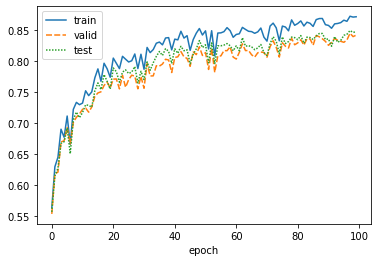

In [36]:
sns.lineplot(data=df_curves)

In [37]:
b = torch.tensor([[1, 1,1,1,2,2,2,2], [3,3,3,3, 4,4,4,4], [5,5,5,5, 6,6,6,6]])

In [38]:
b

tensor([[1, 1, 1, 1, 2, 2, 2, 2],
        [3, 3, 3, 3, 4, 4, 4, 4],
        [5, 5, 5, 5, 6, 6, 6, 6]])

2.0

In [45]:
b.reshape(b.shape[0],4,b.shape[1] //4)

tensor([[[1, 1],
         [1, 1],
         [2, 2],
         [2, 2]],

        [[3, 3],
         [3, 3],
         [4, 4],
         [4, 4]],

        [[5, 5],
         [5, 5],
         [6, 6],
         [6, 6]]])

In [ ]:
print("h_graph_cat shape:", h_graph_cat.shape)

### Generate datapartitions (i.e. train/val, test indices)

In [ ]:
dpartitions = get_stratified_partitions(y, num_folds=5, valid_set_portion=0.1, random_state=42)

In [ ]:
# dump data on disk
# targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

### Create Tensors

In [ ]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

### Using masking and inference with gip computation

In [ ]:
gip_perfold = {}
for fold_id in dpartitions:
    masked_intermat = interaction_mat.copy()
    masked_intermat = masked_intermat.astype(np.float)
    for dsettype in ('validation', 'test'):
        # get validation/test ddi pair indices
        sids = dpartitions[fold_id][dsettype]
        a = [sid_ddipairs_map[sid][0] for sid in sids]
        b = [sid_ddipairs_map[sid][1] for sid in sids]
        # set to nan
        masked_intermat[tuple([a,b])] = np.nan
        masked_intermat[tuple([b,a])] = np.nan
        
    intermat_infer_lst = []
    nanw_mat_lst = []
    for similarity_type in similarity_types:
        print('similarity_type', similarity_type)
        siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
        sim_mat = get_similarity_matrix(siminput_feat_pth, DSdataset_name)
        imat_infer, nanw_m = impute_nan(masked_intermat, sim_mat, k=15)
        intermat_infer_lst.append(imat_infer)
        nanw_mat_lst.append(nanw_m)
        
    infer_mat_fus = weight_inferred_mat(nanw_mat_lst, intermat_infer_lst)

    print('norm(infer_mat-interaction_mat)', np.linalg.norm(infer_mat_fus - interaction_mat))

    # compute GIP here
    gip_kernel = compute_gip_kernel(infer_mat_fus, 1., kernel_option)
    print('norm(gip_kernel-interaction_mat)',np.linalg.norm(gip_kernel - interaction_mat))
    t = gip_kernel-interaction_mat
    print(np.sum(np.abs(t) > 0.5)/(t.size - t.shape[0]))
    gip_perfold[fold_id] = gip_kernel

### Compute features from similarity matrices

#### check if similarity matrix is symmetric

In [ ]:
num_sim_types = len(similarity_types)
for similarity_type in similarity_types:
    siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
    sim_mat = get_similarity_matrix(siminput_feat_pth, DSdataset_name)   
    print(np.allclose(sim_mat, np.transpose(sim_mat)))

In [ ]:
num_sim_types = len(similarity_types)
X_feats = []
for similarity_type in similarity_types:
    siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
    X_feat = preprocess_features(siminput_feat_pth, DSdataset_name, fill_diag=None)   
    X_feats.append(X_feat)
X_feat_cat = np.concatenate(X_feats, axis=1)
print("X_feat_cat", X_feat_cat.shape)

In [ ]:
X = create_setvector_features(X_feat_cat, 2*num_sim_types)
X.shape

In [ ]:
X_a = X[:,list(range(0,2*num_sim_types,2))].copy()
X_b = X[:,list(range(1,2*num_sim_types,2))].copy()

In [ ]:
from ddi.utilities import format_bytes
print(format_bytes(X_feat_cat.size * X_feat_cat.itemsize))
print(format_bytes(y.size * y.itemsize))

In [ ]:
# clear unused objects
del X_feats
del X_feat_cat
del X_feat

In [ ]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

In [ ]:
# dtype is float32 since we will use sigmoid (binary outcome)
y_tensor = torch.tensor(y, dtype = torch.int64, device = device_cpu) 
X_a = torch.tensor(X_a, dtype = torch.float32, device = device_cpu)
X_b = torch.tensor(X_b, dtype = torch.float32, device = device_cpu)
ddi_datatensor = DDIDataTensor(X_a, X_b, y_tensor)

In [ ]:
targetdata_dir

In [ ]:
# dump data on disk
ReaderWriter.dump_tensor(X_a, os.path.join(targetdata_dir, 'X_a.torch'))
ReaderWriter.dump_tensor(X_b, os.path.join(targetdata_dir, 'X_b.torch'))
ReaderWriter.dump_tensor(y_tensor, os.path.join(targetdata_dir, 'y_tensor.torch'))

### Construct GIP datatensor for each fold

In [ ]:
gip_dtensor_perfold = {}
for fold_id in gip_perfold:
    print('fold_id:', fold_id)
    gip_mat = gip_perfold[fold_id]
    print('gip_mat:', gip_mat.shape)
    gip_feat = get_features_from_simmatrix(gip_mat)
    gip_all = create_setvector_features(gip_feat, 2)
    print('gip_all:', gip_all.shape)
    X_a_gip = gip_all[:,list(range(0,2*1,2))].copy()
    X_b_gip = gip_all[:,list(range(1,2*1,2))].copy()
    print('X_a_gip:', X_a_gip.shape)
    X_a_gip = torch.tensor(X_a_gip, dtype = torch.float32, device = device_cpu)
    X_b_gip = torch.tensor(X_b_gip, dtype = torch.float32, device = device_cpu)
    gip_datatensor = GIPDataTensor(X_a_gip, X_b_gip)
    gip_dtensor_perfold[fold_id] = gip_datatensor

In [ ]:
# dump data on disk
ReaderWriter.dump_tensor(gip_dtensor_perfold, os.path.join(targetdata_dir, 'gip_dtensor_perfold.torch'))